## **Plant Classifier and Information Retrieval System**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Plant Classification and detection

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

#### Dataset is split into train, test and validate datasets

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
original_dataset_path = "/content/drive/MyDrive/Augmented_Set"
output_base_path = "/content/drive/MyDrive/updated dataset"

train_dataset_path = os.path.join(output_base_path, "train")
valid_dataset_path = os.path.join(output_base_path, "validate")
test_dataset_path = os.path.join(output_base_path, "test")

os.makedirs(train_dataset_path, exist_ok=True)
os.makedirs(valid_dataset_path, exist_ok=True)
os.makedirs(test_dataset_path, exist_ok=True)

for plant in os.listdir(original_dataset_path):
    plant_folder = os.path.join(original_dataset_path, plant)

    if os.path.isdir(plant_folder):
        images = os.listdir(plant_folder)

        train_images, remainder_images = train_test_split(images, test_size=0.3, random_state=42)

        valid_images, test_images = train_test_split(remainder_images, test_size=0.33, random_state=42)  # 0.33 of 30% = 10%

        train_plant_path = os.path.join(train_dataset_path, plant)
        valid_plant_path = os.path.join(valid_dataset_path, plant)
        test_plant_path = os.path.join(test_dataset_path, plant)

        os.makedirs(train_plant_path, exist_ok=True)
        os.makedirs(valid_plant_path, exist_ok=True)
        os.makedirs(test_plant_path, exist_ok=True)

        for image in train_images:
            shutil.copy(os.path.join(plant_folder, image), os.path.join(train_plant_path, image))
        for image in valid_images:
            shutil.copy(os.path.join(plant_folder, image), os.path.join(valid_plant_path, image))
        for image in test_images:
            shutil.copy(os.path.join(plant_folder, image), os.path.join(test_plant_path, image))

print("Dataset has been successfully split into train, validate, and test sets!")


In [5]:
def prepare_data(train_path,validate_path,  test_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(train_path, transform=transform)
    validate_dataset = datasets.ImageFolder(validate_path, transform=transform)
    test_dataset = datasets.ImageFolder(test_path, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader,validate_loader, test_loader, train_dataset,validate_dataset, test_dataset

train_path = '/content/drive/MyDrive/updated dataset/train'
validate_path = '/content/drive/MyDrive/updated dataset/validate'
test_path = '/content/drive/MyDrive/updated dataset/test'

train_loader,validate_loader, test_loader, train_dataset,validate_dataset, test_dataset = prepare_data(train_path, validate_path, test_path)


In [ ]:
'''
ResNet50 model is used here for training the plant classification model. 
The penultimate layer is used for generating feature vectors of 19 classes for predicting 19 types of plants. 
'''

def initialize_model(num_classes=19):
    resnet = models.resnet50(pretrained=True)
    resnet.fc = nn.Identity()
    penultimate_layer = nn.Linear(2048, num_classes)

    model = nn.Sequential(
        resnet,
        penultimate_layer
    )

    return model.to('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 19
model = initialize_model(num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


### Model training

In [7]:
def validate_model(model, validate_loader, device='cpu', num_classes=19):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    criterion = torch.nn.BCEWithLogitsLoss()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            outputs = model(inputs)
            labels = torch.nn.functional.one_hot(labels.long(), num_classes=num_classes).float().to(device)
            loss = criterion(outputs, labels)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).all(axis=1).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct / total
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Validation Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    return total_loss, accuracy, precision, recall, f1


In [ ]:
import torch
from tqdm import tqdm

def train_model_with_validation(model, train_loader, validate_loader, num_classes=19, num_epochs=10, learning_rate=0.001, save_path='/content/drive/MyDrive/model_weights.pth'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_accuracy = 0.0  
    best_model_weights = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.float().to(device)

            outputs = model(inputs)
            labels = torch.nn.functional.one_hot(labels.long(), num_classes=num_classes).float().to(device)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).all(axis=1).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

        train_accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        print(f"--- Validation Results for Epoch {epoch+1} ---")
        _,val_accuracy,_,_,_ = validate_model(model, validate_loader, device=device, num_classes=num_classes)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_weights = model.state_dict()
            torch.save(best_model_weights, save_path)
            print(f"Improved Validation Accuracy. Saved model with accuracy: {best_val_accuracy:.4f}")

    print(f"Training complete. Best validation accuracy: {best_val_accuracy:.4f}")
    return model


In [12]:
print('-----------------------------Evaluation Metrics----------------------------------')
train_model_with_validation(model, train_loader, validate_loader, num_classes=num_classes, num_epochs=10, learning_rate=0.0008)
print('---------------------------------------------------------------------------------')

-----------------------------Evaluation Metrics----------------------------------


100%|██████████| 28/28 [08:21<00:00, 17.90s/it]


Epoch [1/10], Train Loss: 2.3560, Train Accuracy: 0.6012
--- Validation Results for Epoch 1 ---
Validation Loss: 1.1099, Accuracy: 0.4718, Precision: 0.9575, Recall: 0.9618, F1-Score: 0.9586
Improved Validation Accuracy. Saved model with accuracy: 0.4718


100%|██████████| 28/28 [02:35<00:00,  5.55s/it]


Epoch [2/10], Train Loss: 1.6298, Train Accuracy: 0.7491
--- Validation Results for Epoch 2 ---
Validation Loss: 0.6338, Accuracy: 0.5968, Precision: 0.9726, Recall: 0.9737, F1-Score: 0.9730
Improved Validation Accuracy. Saved model with accuracy: 0.5968


100%|██████████| 28/28 [02:35<00:00,  5.56s/it]


Epoch [3/10], Train Loss: 1.2065, Train Accuracy: 0.8254
--- Validation Results for Epoch 3 ---
Validation Loss: 0.3962, Accuracy: 0.7540, Precision: 0.9828, Recall: 0.9834, F1-Score: 0.9829
Improved Validation Accuracy. Saved model with accuracy: 0.7540


100%|██████████| 28/28 [02:38<00:00,  5.66s/it]


Epoch [4/10], Train Loss: 0.9695, Train Accuracy: 0.9064
--- Validation Results for Epoch 4 ---
Validation Loss: 0.4402, Accuracy: 0.7339, Precision: 0.9801, Recall: 0.9807, F1-Score: 0.9803


100%|██████████| 28/28 [02:38<00:00,  5.64s/it]


Epoch [5/10], Train Loss: 1.0235, Train Accuracy: 0.9133
--- Validation Results for Epoch 5 ---
Validation Loss: 0.5448, Accuracy: 0.6815, Precision: 0.9740, Recall: 0.9750, F1-Score: 0.9744


100%|██████████| 28/28 [02:37<00:00,  5.64s/it]


Epoch [6/10], Train Loss: 0.7837, Train Accuracy: 0.9526
--- Validation Results for Epoch 6 ---
Validation Loss: 0.3103, Accuracy: 0.8669, Precision: 0.9905, Recall: 0.9907, F1-Score: 0.9905
Improved Validation Accuracy. Saved model with accuracy: 0.8669


100%|██████████| 28/28 [02:39<00:00,  5.70s/it]


Epoch [7/10], Train Loss: 0.8817, Train Accuracy: 0.9399
--- Validation Results for Epoch 7 ---
Validation Loss: 0.3768, Accuracy: 0.7903, Precision: 0.9865, Recall: 0.9866, F1-Score: 0.9865


100%|██████████| 28/28 [02:37<00:00,  5.63s/it]


Epoch [8/10], Train Loss: 0.8130, Train Accuracy: 0.9272
--- Validation Results for Epoch 8 ---
Validation Loss: 0.1181, Accuracy: 0.9274, Precision: 0.9947, Recall: 0.9947, F1-Score: 0.9947
Improved Validation Accuracy. Saved model with accuracy: 0.9274


100%|██████████| 28/28 [02:40<00:00,  5.72s/it]


Epoch [9/10], Train Loss: 0.5446, Train Accuracy: 0.9526
--- Validation Results for Epoch 9 ---
Validation Loss: 0.1012, Accuracy: 0.9395, Precision: 0.9953, Recall: 0.9953, F1-Score: 0.9953
Improved Validation Accuracy. Saved model with accuracy: 0.9395


100%|██████████| 28/28 [02:39<00:00,  5.68s/it]


Epoch [10/10], Train Loss: 0.5760, Train Accuracy: 0.9595
--- Validation Results for Epoch 10 ---
Validation Loss: 0.4992, Accuracy: 0.7944, Precision: 0.9838, Recall: 0.9841, F1-Score: 0.9839
Training complete. Best validation accuracy: 0.9395
---------------------------------------------------------------------------------


### Testing

<ipython-input-13-57de9c7a806a>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', num_clusters)


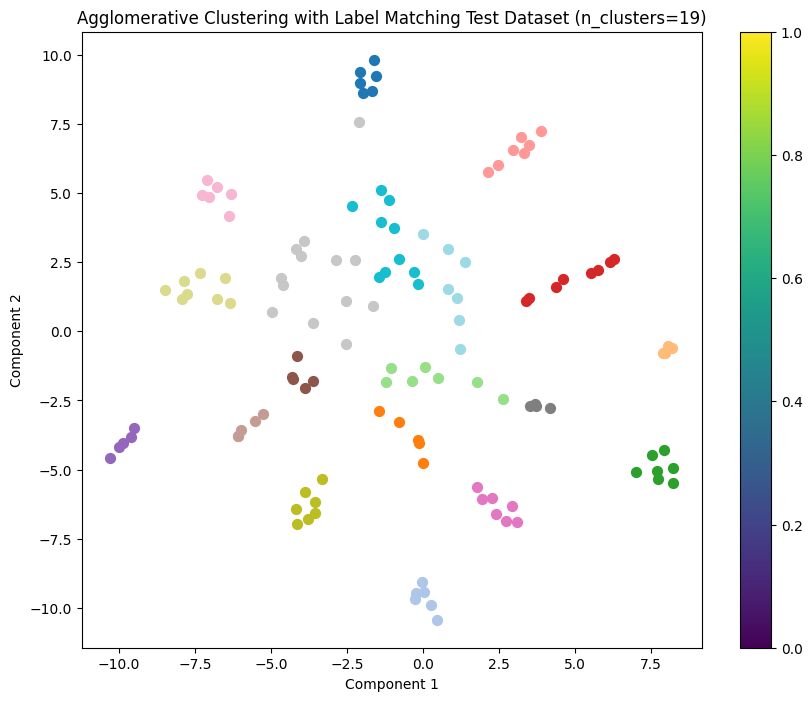

In [13]:
import numpy as np
import torch
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linear_sum_assignment

def extract_features_and_cluster_agglomerative_with_label_matching(model, test_loader, num_clusters=19):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()

    features_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            features_list.append(outputs.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features_array = np.vstack(features_list)
    labels_array = np.hstack(labels_list)

    scaler = StandardScaler()
    features_array = scaler.fit_transform(features_array)

    agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
    cluster_labels = agglomerative.fit_predict(features_array)

    confusion_matrix = np.zeros((num_clusters, len(np.unique(labels_array))))

    for cluster, label in zip(cluster_labels, labels_array):
        confusion_matrix[cluster, label] += 1

    row_ind, col_ind = linear_sum_assignment(-confusion_matrix)

    mapped_labels = np.copy(cluster_labels)
    for cluster, true_label in zip(row_ind, col_ind):
        mapped_labels[cluster_labels == cluster] = true_label

    return features_array, labels_array, mapped_labels

def visualize_clusters(features_array, mapped_labels, num_clusters=19, use_tsne=False):
    if use_tsne:
        reducer = TSNE(n_components=2, random_state=42)
        reduced_features = reducer.fit_transform(features_array)
    else:
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(features_array)

    plt.figure(figsize=(10, 8))

    colors = cm.get_cmap('tab20', num_clusters)

    for label in range(num_clusters):
        cluster_points = reduced_features[mapped_labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    color=colors(label), label=f'Cluster {label + 1}', s=50)

    plt.colorbar()
    plt.title(f"Agglomerative Clustering with Label Matching Test Dataset (n_clusters={num_clusters})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

features, labels, mapped_labels = extract_features_and_cluster_agglomerative_with_label_matching(model, test_loader, num_clusters=19)
visualize_clusters(features, mapped_labels, num_clusters=19, use_tsne=True)

In [14]:
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score

def evaluate_model_metrics(model, test_loader, weights_path, device='cpu'):
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    cm = confusion_matrix(y_true, y_pred)

    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    return accuracy, precision, recall, f1, cm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
weights_path = '/content/drive/MyDrive/model_weights.pth'
accuracy, precision, recall, f1, cm = evaluate_model_metrics(model, test_loader, weights_path, device=device)


<ipython-input-14-8cb8a27983ed>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


Accuracy: 0.9449
Precision: 0.9696
Recall: 0.9449
F1-Score: 0.9455

Confusion Matrix:
[[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
 

In [15]:
def image_dataset(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_dataset = datasets.ImageFolder(image_path, transform=transform)
    image_loader = DataLoader(image_dataset, batch_size=32, shuffle=False)
    return image_loader,image_dataset

image_path = '/content/drive/MyDrive/Augmented_Set'
image_loader,image_dataset = image_dataset(image_path)

In [ ]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
from torchvision import transforms
from PIL import Image
import numpy as np

def preprocess_input_leaf(leaf_path, input_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(leaf_path).convert('RGB')
    return transform(image).unsqueeze(0)

def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            lbls = lbls.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.extend(lbls.cpu().numpy())

    features = np.vstack(features)
    labels = np.array(labels)
    return features, labels

def find_similarity_for_leaf(model, leaf_image_path, features, labels, plant_names, device, input_size=(224, 224)):
    input_leaf = preprocess_input_leaf(leaf_image_path, input_size)

    model.eval()
    with torch.no_grad():
        input_leaf = input_leaf.to(device)
        leaf_features = model(input_leaf).cpu().numpy()

    similarities = cosine_similarity(leaf_features, features)
    plant_similarities = {}

    for label in np.unique(labels):
        label_indices = np.where(labels == label)[0]
        label_similarities = similarities[0][label_indices]
        mean_similarity = label_similarities.mean()
        plant_similarities[plant_names[label]] = mean_similarity

    sorted_plant_similarities = sorted(plant_similarities.items(), key=lambda x: x[1], reverse=True)

    print("Top 5 Similar Plants:")
    top_5_plants = sorted_plant_similarities[:5]
    for plant, similarity in top_5_plants:
        print(f"Plant: {plant}, Similarity: {similarity:.4f}")

    return top_5_plants


device = 'cuda' if torch.cuda.is_available() else 'cpu'
weights_path = '/content/drive/MyDrive/model_weights.pth'
model.load_state_dict(torch.load(weights_path, map_location=device))
model.to(device)

features, labels = extract_features(model, test_loader, device)
plant_names = test_dataset.classes

leaf_image_path = '/content/drive/MyDrive/Augmented_Set/betel/IMG_7322_aug_3.jpg'
top_5_plants = find_similarity_for_leaf(model, leaf_image_path, features, labels, plant_names, device)
for rank, (plant, similarity) in enumerate(top_5_plants, start=1):
    print(f"{rank}. {plant}: {similarity:.4f}")


<ipython-input-21-22c9e0b0bbc5>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


Top 5 Similar Plants:
Plant: betel, Similarity: 0.9967
Plant: clove, Similarity: 0.8384
Plant: Ixora coccinea, Similarity: 0.8289
Plant: Hydrangea, Similarity: 0.8274
Plant: centella_asiatica, Similarity: 0.8272
1. betel: 0.9967
2. clove: 0.8384
3. Ixora coccinea: 0.8289
4. Hydrangea: 0.8274
5. centella_asiatica: 0.8272


## Information Retrieval (information generation code):
#### Finetuning code is in finetune.ipynb file

In [27]:
!pip install transformers
!pip install wikipedia-api
!pip install datasets

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.7.1-py3-none-any.whl size=14346 sha256=d2726c282e61e46893badd7e572bfab5d10e8cd1b257f4f2b349f6e8815c0709
  Stored in directory: /root/.cache/pip/wheels/4c/96/18/b9201cc3e8b47b02b510460210cfd832ccf10c0c4dd0522962
Successfully built wikipedia-api
  Using cached datasets-3.1.0-py3-none-any.whl.metadata (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependenc

In [28]:
import pandas as pd
import numpy as np
import wikipediaapi
import torch
from torch import nn
import torch.nn.functional as F
# import faiss
from datasets import Dataset
from transformers import get_scheduler
import re
from transformers import (DPRContextEncoderTokenizer, DPRQuestionEncoderTokenizer, DPRQuestionEncoder, DPRContextEncoder, DPRReader, Trainer, TrainingArguments)
import random

In [29]:
import torch

if torch.cuda.is_available():
    print("GPU is available:", torch.cuda.get_device_name(0))
else:
    print("GPU not available. Check runtime settings.")

GPU is available: Tesla T4


In [30]:
wiki = wikipediaapi.Wikipedia('plantInfoRetrieval(haricharangoudca1@gmail.com)', 'en' )

def fetch_page(plant_name):
  page = wiki.page(plant_name)
  if page.exists:
    return page.text
  else:
    return None

In [31]:
model_save_path = "/content/drive/MyDrive/fine_tuned_model"

In [39]:
def create_dense_layer(input_size, output_size):
    return nn.Sequential(
        nn.Linear(input_size, output_size * 2),
        nn.ReLU(),
        nn.Linear(output_size * 2, output_size),
        nn.GELU(),
    )

model_save_path = "/content/drive/MyDrive/fine_tuned_model"
query_model = DPRQuestionEncoder.from_pretrained(f"{model_save_path}/query_model")
passage_model = DPRContextEncoder.from_pretrained(f"{model_save_path}/passage_model")
query_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
passage_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

dense_size = 128
passage_dense_layer = create_dense_layer(768, dense_size)
query_dense_layer = create_dense_layer(768, dense_size)

passage_dense_layer.load_state_dict(torch.load(f"{model_save_path}/passage_dense_layer.pth"))
query_dense_layer.load_state_dict(torch.load(f"{model_save_path}/query_dense_layer.pth"))

passage_dense_layer.eval()
query_dense_layer.eval()

def extract_relevant_info(text):
    family_name = None
    description = None
    uses = None

    family_pattern = re.search(
        r"(?i)((\b(plant\s*family|family\s*name|genus)\s*[:\-]?\s*[\w\s]+)|" +
        r"belongs\s+to\s+the\s+(family|genus)\b.*?\." +
        r"|is\s+a\s+member\s+of\s+the\s+(family|genus)\b.*?\." +
        r"|classified\s+under\s+(the\s+family|the\s+genus)\b.*?\." +
        r"|is\s+from\s+the\s+(family|genus)\b.*?\." +
        r"|related\s+to\s+(the\s+family|the\s+genus)\b.*?\.)", text)

    description_pattern = re.search(
        r"(?i)(\b\w+\s+(is|are)\s+(a|an|widely|commonly|known|characterized|used|identified)\b.*?\." +
        r"|belongs\s+to\b.*?\." +
        r"|has\s+(properties|features|characteristics)\b.*?\." +
        r"|can\s+be\s+(identified|used|found)\b.*?\.)", text)

    uses_pattern = re.search(r"(?i)(uses\s*[:\-]?\s*([^.]+))", text)

    if family_pattern:
        family_name = family_pattern.group(0).strip()

    if description_pattern:
        description = description_pattern.group(0).strip()

    if uses_pattern:
        uses = uses_pattern.group(2).strip()

    if description:
        description = limit_text_length(description, min_length=50, max_length=100)

    if uses:
        uses = limit_text_length(uses, min_length=50, max_length=100)

    if not description:
        description = extract_first_sentences(text, num_sentences=2)

    return {
        "family_name": family_name,
        "description": description,
        "uses": uses
    }

def limit_text_length(text, min_length=50, max_length=200):
    words = text.split()
    if len(words) > max_length:
        text = " ".join(words[:max_length]) + "..."
    elif len(words) < min_length:
        text = " ".join(words + ['...'])
    return text


def extract_first_sentences(text, num_sentences=2):
    sentences = text.split(". ")
    return ". ".join(sentences[:num_sentences]) + ("" if text.endswith(".") else ".")


def retrieve_relevant_documents(query):
    document_text = fetch_page(query)

    if not document_text:
        return ["Sorry, no relevant information found."]

    return extract_relevant_info(document_text)

def predict(user_input):
    user_input = str(user_input)
    query_tensor = query_tokenizer(user_input, padding='longest', truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        dense_query = query_model(**query_tensor)['pooler_output']
    dense_query = query_dense_layer(dense_query)

    relevant_info = retrieve_relevant_documents(user_input)

    document_list = [f"Family: {relevant_info.get('family_name', 'Not available')}\nDescription: {relevant_info.get('description', 'Not available')}\nUses: {relevant_info.get('uses', 'Not available')}"]

    passage_tensor = passage_tokenizer(document_list, padding='longest', truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        dense_passage = passage_model(input_ids=passage_tensor['input_ids'], attention_mask=passage_tensor['attention_mask'])['pooler_output']
    dense_passage = passage_dense_layer(dense_passage)

    similarity_scores = torch.matmul(dense_query, dense_passage.transpose(-2, -1)).squeeze()
    most_similar_index = torch.argmax(similarity_scores).item()

    return document_list[most_similar_index]

user_input = input("Enter your query: ")
output = predict(user_input)
print(f"\nRelevant Information:\n{output}")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.
<ipython-input-39-471743154711>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_

Enter your query: Mango

Relevant Information:
Family: genus Mangifera also produce edible fruits that are also called
Description: mango is an edible stone fruit produced by the tropical tree Mangifera indica. ...
Uses: Culinary Mangoes are generally sweet, although the taste and texture of the flesh vary across cultivars; some, such as Alphonso, have a soft, pulpy, juicy texture similar to an overripe plum, while others, such as Tommy Atkins, are firmer with a fibrous texture ...


### Generated output

In [ ]:
features, labels = extract_features(model, test_loader, device)
plant_names = test_dataset.classes
leaf_image_path = '/content/drive/MyDrive/Augmented_Set/betel/IMG_7322_aug_3.jpg'
top_5_plants = find_similarity_for_leaf(model, leaf_image_path, features, labels, plant_names, device)

plants = [plant for plant, _ in top_5_plants]
print("Top 5 Plant Names:", plants)

Top 5 Similar Plants:
Plant: betel, Similarity: 0.9967
Plant: clove, Similarity: 0.8384
Plant: Ixora coccinea, Similarity: 0.8289
Plant: Hydrangea, Similarity: 0.8274
Plant: centella_asiatica, Similarity: 0.8272
Top 5 Plant Names: ['betel', 'clove', 'Ixora coccinea', 'Hydrangea', 'centella_asiatica']


In [45]:
for plant in plants:
    output = predict(plant)
    print(f"\nRelevant Information for {plant}:\n{output}")


Relevant Information for betel:
Family: None
Description: It is an evergreen, dioecious vine, with glossy heart-shaped leaves and white catkins. ...
Uses: esophageal cancer, and in some instances, liver cancer ...

Relevant Information for clove:
Family: None
Description: and are commonly used as a spice, flavoring, or fragrance in consumer products, such as toothpaste, soaps, or cosmetics. ...
Uses: Cloves are used in the cuisine of Asian, African, Mediterranean, and the Near and Middle East countries, lending flavor to meats (such as baked ham), curries, and marinades, as well as fruit (such as apples, pears, and rhubarb) ...

Relevant Information for Ixora coccinea:
Family: genus Ixora
Description: It is a common flowering shrub native to Southern India, Bangladesh, and Sri Lanka. ...
Uses: None

Relevant Information for Hydrangea:
Family: genus of more than 70 species of flowering plants native to Asia and the Americas
Description: alaskana is a fossil species recovered from Paleo